In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')



In [2]:
df= pd.read_csv('../input/price/baechu(lstm).csv',encoding='cp949')
df.head()

,date,uga,ondo,gangsu,price
0,2015-01-02,53.27,-10.6,0.0,380
1,2015-01-05,50.98,-1.6,0.7,380
2,2015-01-06,48.08,-3.6,1.4,380
3,2015-01-07,46.60,-11.2,0.0,380
4,2015-01-08,47.50,-10.6,0.0,380


In [3]:
uga=df['uga']
ondo=df['ondo']
gangsu=df['gangsu']
price=df['price']
date=['date']

Text(0.5, 1.0, 'price')

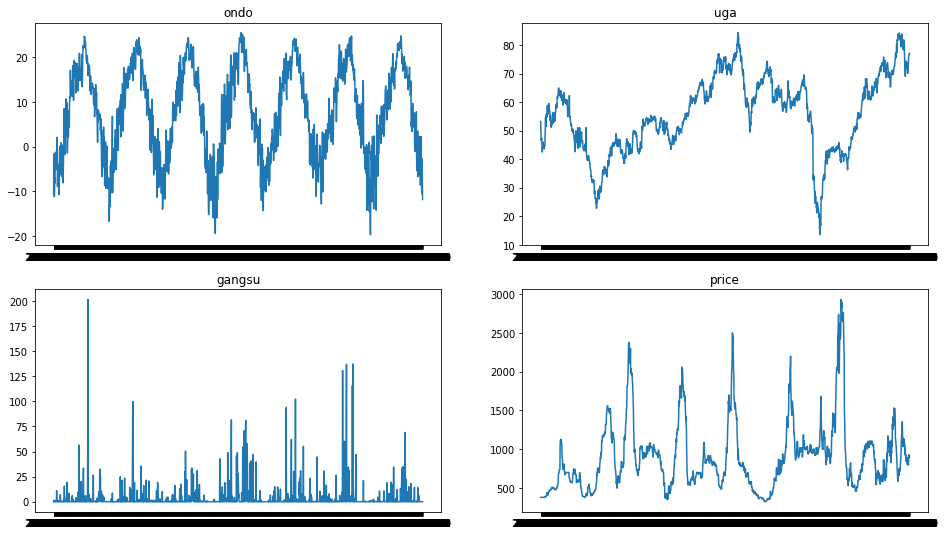

In [4]:
plt.figure(figsize=(16, 9))
plt.subplot(221)
plt.plot(df['date'], df['ondo'],label='ondo')
plt.title('ondo')

plt.subplot(222)
plt.plot(df['date'], df['uga'],label='uga')
plt.title('uga')

plt.subplot(223)
plt.plot(df['date'], df['gangsu'],label='gangsu')
plt.title('gangsu')

plt.subplot(224)
plt.plot(df['date'], df['price'],label='price')
plt.title('price')

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['uga', 'ondo', 'gangsu', 'price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.56049069, 0.20132743, 0.        , 0.02148887],
       [0.52820079, 0.40044248, 0.00347395, 0.02148887],
       [0.48730964, 0.35619469, 0.00694789, 0.02148887],
       ...,
       [0.89382403, 0.37610619, 0.        , 0.22947045],
       [0.89847716, 0.24336283, 0.        , 0.23100537],
       [0.89678511, 0.17477876, 0.        , 0.21949348]])

In [6]:
df = pd.DataFrame(scaled, columns=scale_cols)
df

,uga,ondo,gangsu,price
0,0.560491,0.201327,0.000000,0.021489
1,0.528201,0.400442,0.003474,0.021489
2,0.487310,0.356195,0.006948,0.021489
3,0.466441,0.188053,0.000000,0.021489
4,0.479131,0.201327,0.000000,0.021489
...,...,...,...,...
1717,0.882685,0.203540,0.000000,0.230622
1718,0.887620,0.311947,0.000000,0.218726
1719,0.893824,0.376106,0.000000,0.229470
1720,0.898477,0.243363,0.000000,0.231005


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[['ondo', 'gangsu', 'uga']],df['price'],test_size=0.2, random_state=12, shuffle=False)

In [8]:
x_train.shape, y_train.shape

((1377, 3), (1377,))

In [9]:
x_test.shape, y_test.shape

((345, 3), (345,))

In [10]:
x_train

,ondo,gangsu,uga
0,0.201327,0.000000,0.560491
1,0.400442,0.003474,0.528201
2,0.356195,0.006948,0.487310
3,0.188053,0.000000,0.466441
4,0.201327,0.000000,0.479131
...,...,...,...
1372,0.900442,0.141439,0.408347
1373,0.942478,0.063027,0.415257
1374,0.913717,0.066998,0.426396
1375,0.920354,0.171712,0.425691


In [11]:
y_test

1377    0.517268
1378    0.571757
1379    0.607061
1380    0.633154
1381    0.663853
          ...   
1717    0.230622
1718    0.218726
1719    0.229470
1720    0.231005
1721    0.219493
Name: price, Length: 345, dtype: float64

In [12]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [14]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

2022-07-12 10:19:53.733494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 10:19:53.859962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 10:19:53.861037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 10:19:53.864902: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

2022-07-12 10:19:56.705842: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh',return_sequences = True),
    LSTM(32, activation='relu',return_sequences = True),
    LSTM(64, activation='relu',return_sequences = True),
    LSTM(128, activation='relu',return_sequences = False),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16, activation="relu"),
    Dense(1),
])


In [17]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [18]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [19]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=200, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200


2022-07-12 10:20:03.219945: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


43/43 [==============================] - 18s 154ms/step - loss: 0.0170 - mse: 0.0340 - val_loss: 0.0117 - val_mse: 0.0235

Epoch 00001: val_loss improved from inf to 0.01173, saving model to tmp/ckeckpointer.ckpt
Epoch 2/200
43/43 [==============================] - 6s 138ms/step - loss: 0.0060 - mse: 0.0120 - val_loss: 0.0091 - val_mse: 0.0181

Epoch 00002: val_loss improved from 0.01173 to 0.00906, saving model to tmp/ckeckpointer.ckpt
Epoch 3/200
43/43 [==============================] - 6s 142ms/step - loss: 0.0048 - mse: 0.0096 - val_loss: 0.0085 - val_mse: 0.0171

Epoch 00003: val_loss improved from 0.00906 to 0.00853, saving model to tmp/ckeckpointer.ckpt
Epoch 4/200
43/43 [==============================] - 7s 169ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0062 - val_mse: 0.0125

Epoch 00004: val_loss improved from 0.00853 to 0.00623, saving model to tmp/ckeckpointer.ckpt
Epoch 5/200
43/43 [==============================] - 6s 134ms/step - loss: 0.0028 - mse: 0.0055 - val_l

In [20]:
pred = model.predict(test_data)

In [21]:
pred.shape

(325, 1)

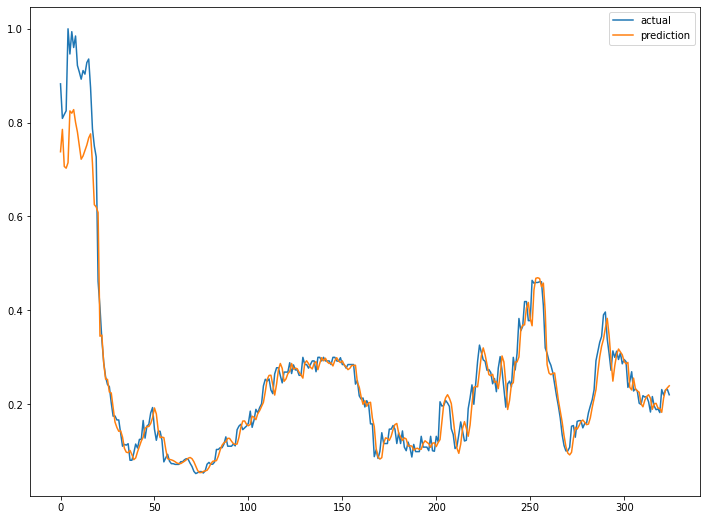

In [22]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [23]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

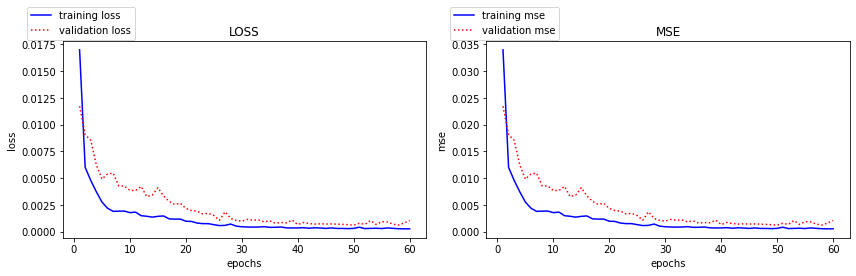

In [24]:
plot_history(history)

In [35]:
import tensorflow.keras as keras

In [54]:
x_test_t = x_test.values.reshape(x_test.shape[0], 3, 1)
y_test_t = y_test.values.reshape(y_test.shape[0], 1)

In [55]:
score=model.evaluate(x_test_t,y_test,batch_size=32)

11/11 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0666


In [26]:
model.save('baechu2.h5')

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

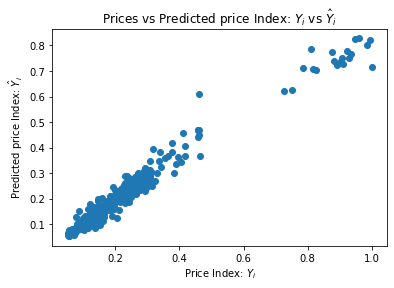

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt


y_pred = model.predict(train_data, batch_size=32)
plt.scatter(y_test[20:], pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")